In [1]:
import lightkurve as lk
from vetting import centroid_test

In [2]:
tic, sector = 18016577, 48  # with the period, the expected dip in sector 22 occurs in data gap, so it is not helpful

period = 35.8648067
t0 = 2630.3051774
duration = 4.6054948 / 24

In [3]:
download_dir = "data"

sr = lk.search_targetpixelfile(f"TIC {tic}", mission='TESS', sector=sector)
tpf = sr.download(download_dir=download_dir)
tpf

TessTargetPixelFile(TICID: 18016577)

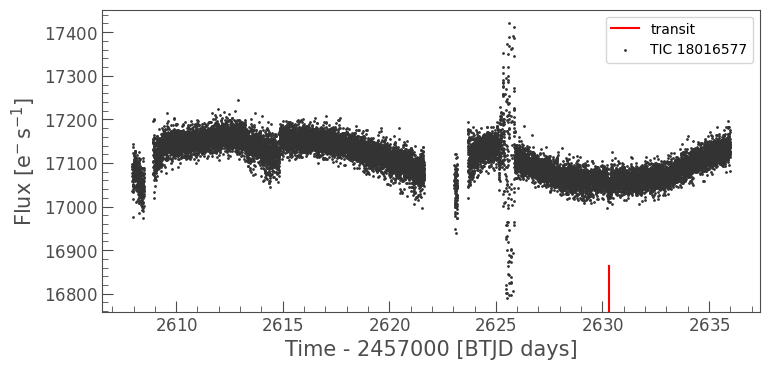

In [12]:
ax = tpf.to_lightcurve().remove_outliers(sigma=7).scatter();
ax.axvline(t0, c='red', ymax=0.15, label="transit");
ax.legend();

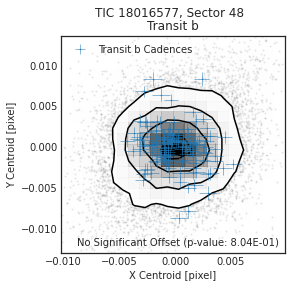

In [6]:
# if p-value is < 0.05 (5%), it means signficant centroid offset
# - distribution of centroid outside dips are not from the same population of the centroid during dips
r = centroid_test(tpf, period, t0, duration, aperture_mask='pipeline', plot=True);